# Caltech101 dataset object classification using pre-trained CNNs

This code is inspired/copied by the repository https://github.com/fchollet/deep-learning-with-python-notebooks that has the code from book "Deep Learning with Python".

More specifically, I am running code from the notebooks:
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

adapted to the Caltech101 dataset. Please refer to the original Jupyter Notebooks above for further info.

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import numpy as np
import cv2
from matplotlib import pyplot as plt

import keras
print("keras version: ", keras.__version__)

import tensorflow as tf
print("tensoflow version: ", tf.__version__)

/home/tbontz2s/anaconda3_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


keras version:  2.2.2
tensoflow version:  1.9.0


In [2]:
# istructions from: https://michaelblogscode.wordpress.com/2017/10/10/reducing-and-profiling-gpu-memory-usage-in-keras-with-tensorflow-backend/

# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.9
 
# Create a session with the above options specified.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# Using a pre-trained convnet

# Feature extractions

In [3]:
from keras.applications import ResNet50, VGG16

#conv_base = ResNet50(weights='imagenet',
#                  include_top=False,
#                  input_shape=(197, 197, 3))

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Final layer output is <s>(7, 7, 2048)</s> / (4,4,512)

In [5]:

from keras.preprocessing.image import ImageDataGenerator

base_dir = './split_dataset'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 102))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 6353)
validation_features, validation_labels = extract_features(validation_dir, 1788)
test_features, test_labels = extract_features(test_dir, 1003)

Found 6353 images belonging to 102 classes.
Found 1788 images belonging to 102 classes.
Found 1003 images belonging to 102 classes.


We used an existing VGG16 network to extract features from the images. The extracted features are currently of shape <s>(samples, 7, 7, 2048)</s>(samples, 4, 4, 512). We will feed them to a densely-connected classifier, so first we must flatten them to <s>(samples, 100352)</s>(samples, 8192):

In [6]:
train_features = np.reshape(train_features, (6353, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1788, 4 * 4 * 512))
test_features = np.reshape(test_features, (1003, 4 * 4 * 512))

Train a small network based on the extracted features.

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(102, activation='softmax'))

model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 6353 samples, validate on 1788 samples
Epoch 1/30
6353/6353 [==============================] - 3s 451us/step - loss: 2.2479 - acc: 0.5089 - val_loss: 1.1954 - val_acc: 0.7120
Epoch 2/30
6353/6353 [==============================] - 2s 350us/step - loss: 1.1233 - acc: 0.7053 - val_loss: 0.9192 - val_acc: 0.7696
Epoch 3/30
6353/6353 [==============================] - 2s 354us/step - loss: 0.7966 - acc: 0.7812 - val_loss: 0.7723 - val_acc: 0.7942
Epoch 4/30
6353/6353 [==============================] - 2s 352us/step - loss: 0.5729 - acc: 0.8393 - val_loss: 0.7396 - val_acc: 0.8065
Epoch 5/30
6353/6353 [==============================] - 2s 357us/step - loss: 0.4622 - acc: 0.8615 - val_loss: 0.7426 - val_acc: 0.8076
Epoch 6/30
6353/6353 [==============================] - 2s 350us/step - loss: 0.4001 - acc: 0.8782 - val_loss: 0.7883 - val_acc: 0.7947
Epoch 7/30
6353/6353 [==============================] - 2s 353us/step - loss: 0.3404 - acc: 0.8966 - val_loss: 0.7218 - val_acc: 0.8076


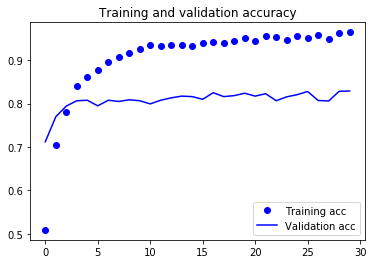

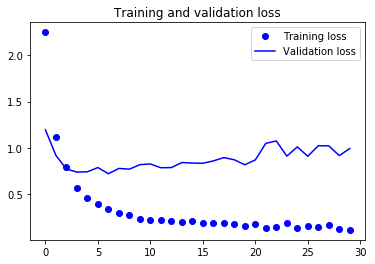

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
model.save('caltech101_pretrained_1.h5')

Validation accuracy is better but the plots shows that there is also overfitting alsmost immediately. Let's use the other more expensive method where we incorporate and freeze the VGG16 in the model and train only part of the network on top.

In [27]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(102, activation='softmax'))

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_10 (Dense)             (None, 102)               52326     
Total params: 18,961,830
Trainable params: 4,247,142
Non-trainable params: 14,714,688
_________________________________________________________________


In [29]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


In [30]:
conv_base.trainable = False

In [31]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [32]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=400,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=80,
      verbose=2)

Found 6353 images belonging to 102 classes.
Found 1788 images belonging to 102 classes.
Epoch 1/30
 - 59s - loss: 2.1893 - acc: 0.4935 - val_loss: 1.1961 - val_acc: 0.6935
Epoch 2/30
 - 58s - loss: 1.2862 - acc: 0.6669 - val_loss: 0.9898 - val_acc: 0.7315
Epoch 3/30
 - 58s - loss: 1.0201 - acc: 0.7228 - val_loss: 1.0427 - val_acc: 0.7226
Epoch 4/30
 - 59s - loss: 0.9060 - acc: 0.7489 - val_loss: 0.9329 - val_acc: 0.7556
Epoch 5/30
 - 57s - loss: 0.8173 - acc: 0.7678 - val_loss: 0.8910 - val_acc: 0.7735
Epoch 6/30
 - 57s - loss: 0.7550 - acc: 0.7865 - val_loss: 0.8807 - val_acc: 0.7701
Epoch 7/30
 - 58s - loss: 0.7221 - acc: 0.7880 - val_loss: 0.8923 - val_acc: 0.7701
Epoch 8/30
 - 59s - loss: 0.6732 - acc: 0.8066 - val_loss: 0.9278 - val_acc: 0.7645
Epoch 9/30
 - 57s - loss: 0.6297 - acc: 0.8171 - val_loss: 0.8891 - val_acc: 0.7836
Epoch 10/30
 - 57s - loss: 0.6336 - acc: 0.8156 - val_loss: 0.9020 - val_acc: 0.7763
Epoch 11/30
 - 58s - loss: 0.5979 - acc: 0.8270 - val_loss: 0.8809 - va

In [33]:
model.save('caltech101_3.h5')

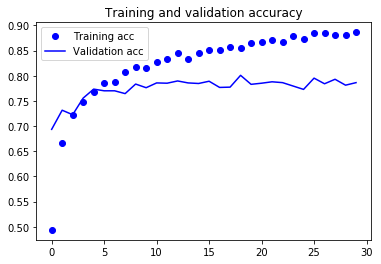

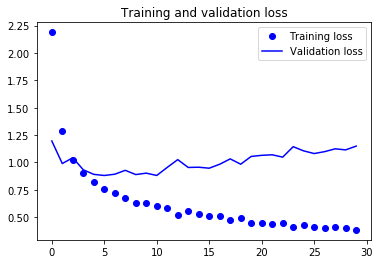

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Almost 77% accuracy. But there is still overfitting.

# Fine-tuning

We got 77% accuracy above. Let's try with fine-tuning.

In [35]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [36]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [38]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=400,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=80)

Epoch 1/30
400/400 [==============================] - 61s 152ms/step - loss: 0.1910 - acc: 0.9410 - val_loss: 1.1043 - val_acc: 0.7975
Epoch 2/30
400/400 [==============================] - 59s 147ms/step - loss: 0.1885 - acc: 0.9425 - val_loss: 1.0200 - val_acc: 0.8015
Epoch 3/30
400/400 [==============================] - 58s 145ms/step - loss: 0.1725 - acc: 0.9461 - val_loss: 1.0143 - val_acc: 0.8076
Epoch 4/30
400/400 [==============================] - 58s 144ms/step - loss: 0.1663 - acc: 0.9493 - val_loss: 1.0324 - val_acc: 0.8132
Epoch 5/30
400/400 [==============================] - 59s 148ms/step - loss: 0.1511 - acc: 0.9537 - val_loss: 1.0034 - val_acc: 0.8110
Epoch 6/30
400/400 [==============================] - 59s 147ms/step - loss: 0.1426 - acc: 0.9559 - val_loss: 1.0440 - val_acc: 0.8132
Epoch 7/30
400/400 [==============================] - 58s 145ms/step - loss: 0.1321 - acc: 0.9569 - val_loss: 1.0090 - val_acc: 0.8194
Epoch 8/30
400/400 [==============================] - 5

In [39]:
model.save('caltech101_4.h5')

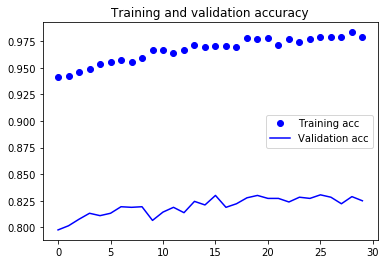

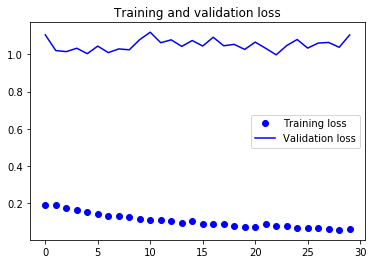

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This is better than before, almost 82%. Gained approximately 5% accuracy on validation set.

Smooth the lines above by _replacing every loss and accuracy with exponential moving averages of these quantities_[see original notebook for more info].

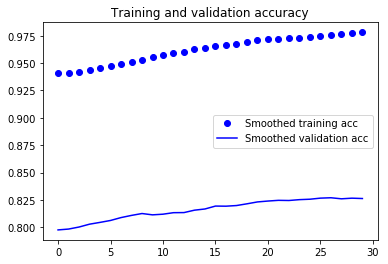

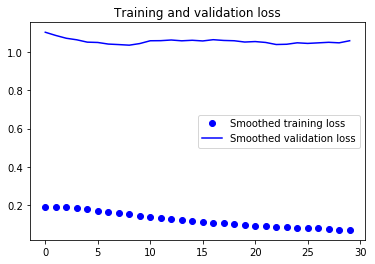

In [41]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [42]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1003 images belonging to 102 classes.
test acc: 0.8350000023841858


83.5% accuracy on the test data. Not bad for such a small dataset. But for better results we need more data.